In [1]:
#Goal:Fall Detection among the elderly people based on health parameters

import pandas as pd
import numpy as np

import mglearn
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('falldetection.csv')

In [2]:
data.columns

Index(['ACTIVITY', 'TIME', 'SL', 'EEG', 'BP', 'HR', 'CIRCLUATION'], dtype='object')

In [3]:
data.head()

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
0,3,4722.92,4019.64,-1600.00,13,79,317
1,2,4059.12,2191.03,-1146.08,20,54,165
2,2,4773.56,2787.99,-1263.38,46,67,224
3,4,8271.27,9545.98,-2848.93,26,138,554
4,4,7102.16,14148.80,-2381.15,85,120,809


In [4]:
# Binarize the Falling Activity to 0  or 1.
#Fall Activity=>0
#Other Activity=>1

clean_data = data.copy()
clean_data['ACTIVITY'] = (clean_data['ACTIVITY']!=3)*1

clean_data.head()

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
0,0,4722.92,4019.64,-1600.00,13,79,317
1,1,4059.12,2191.03,-1146.08,20,54,165
2,1,4773.56,2787.99,-1263.38,46,67,224
3,1,8271.27,9545.98,-2848.93,26,138,554
4,1,7102.16,14148.80,-2381.15,85,120,809


In [5]:
y = clean_data[['ACTIVITY']]
type(y)
y.shape

(16382, 1)

In [6]:
features=['TIME', 'SL', 'EEG', 'BP', 'HR', 'CIRCLUATION']
X = clean_data[features]

In [7]:
#Split Dataset into test and train
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=23)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12286, 6) (4096, 6) (12286, 1) (4096, 1)


In [8]:
#Initialize Comparison variables
comparePrecision=[]
compareRecall=[]
compareAccuracy=[]
compareF1=[]

In [9]:
#Displaying Model Metrics 
def Report(model,X_train,X_test,y_train,y_test,y_pred):
    print('Summary Metrics')
    print('Precision score: {:.4f}'.format(precision_score(y_test,y_pred)))
    comparePrecision.append(precision_score(y_test,y_pred))
    print('Recall score: {:.4f}'.format(recall_score(y_test,y_pred)))
    compareRecall.append(recall_score(y_test,y_pred))
    print('Accuracy score: {:.4f}'.format(accuracy_score(y_test,y_pred)))
    compareAccuracy.append(accuracy_score(y_test,y_pred))
    print('F1 score: {:.4f}'.format(f1_score(y_test,y_pred)))
    compareF1.append(f1_score(y_test,y_pred))
    plt.title("Confusion Matrix")
    sn.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="Blues",fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print('Classification Report')
    print(classification_report(y_test, y_pred))
    print('Train score: ', model.score(X_train, y_train))
    print('Test score: ', model.score(X_test, y_test))
    print('Best Parameters:',model.best_params_)

#Now we will implement Machine Learning Algorithms for binary classification to detect fall

Summary Metrics
Precision score: 0.7768
Recall score: 0.9987
Accuracy score: 0.7761
F1 score: 0.8739


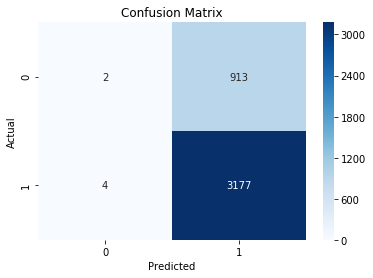

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.00      0.00       915
           1       0.78      1.00      0.87      3181

   micro avg       0.78      0.78      0.78      4096
   macro avg       0.56      0.50      0.44      4096
weighted avg       0.68      0.78      0.68      4096

Train score:  0.7828422594823377
Test score:  0.776123046875
Best Parameters: {'C': 0.1, 'penalty': 'l1'}


In [11]:
#1.Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
# fit the model with data
logreg.fit(X_train,y_train)

#predict y
y_pred_logreg=logreg.predict(X_test)


# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.1,1]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
grid_logreg = GridSearchCV(logreg, hyperparameters, cv=3, verbose=0)

# Fit grid search
grid_logreg.fit(X_train, y_train)
y_pred_logreg = grid_logreg.predict(X_test)

#Model metrics
Report(grid_logreg,X_train,X_test,y_train,y_test,y_pred_logreg)


Summary Metrics
Precision score: 0.7811
Recall score: 0.8840
Accuracy score: 0.7175
F1 score: 0.8294


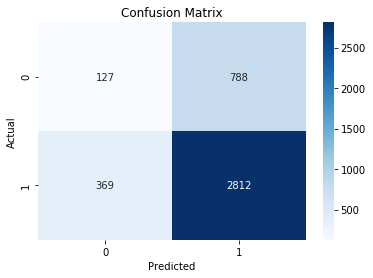

Classification Report
              precision    recall  f1-score   support

           0       0.26      0.14      0.18       915
           1       0.78      0.88      0.83      3181

   micro avg       0.72      0.72      0.72      4096
   macro avg       0.52      0.51      0.50      4096
weighted avg       0.66      0.72      0.68      4096

Train score:  0.5180585945059979
Test score:  0.5148705685911741
Best Parameters: {'C': 1}


In [12]:
#2.Linear SVM

linear_svc = LinearSVC()

#define a list of parameters
params_svc = {'C': [ 0.1, 1, 10]}

grid_svc = GridSearchCV(linear_svc, params_svc, cv=3, n_jobs=2,scoring = 'roc_auc', return_train_score=True)
grid_svc.fit(X_train, y_train)
y_pred_svm = grid_svc.predict(X_test)

#Model metrics
Report(grid_svc,X_train,X_test,y_train,y_test,y_pred_svm)


Summary Metrics
Precision score: 0.7766
Recall score: 1.0000
Accuracy score: 0.7766
F1 score: 0.8743


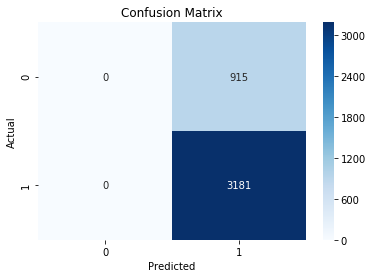

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       915
           1       0.78      1.00      0.87      3181

   micro avg       0.78      0.78      0.78      4096
   macro avg       0.39      0.50      0.44      4096
weighted avg       0.60      0.78      0.68      4096

Train score:  1.0
Test score:  0.5252927645875528
Best Parameters: {'C': 1, 'gamma': 0.1}


In [13]:
#3.SVC Kernel
svc_kernel = SVC(kernel = 'rbf')

#define a list of parameters
param_svc_kernel = {'C': [1],'gamma':[0.1,1]}

#apply grid search
grid_svc_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=3, n_jobs=2, scoring='roc_auc')

grid_svc_kernel.fit(X_train, y_train)

y_pred_svc_kernal = grid_svc_kernel.predict(X_test)


#Model metrics
Report(grid_svc_kernel,X_train,X_test,y_train,y_test,y_pred_svc_kernal)


Summary Metrics
Precision score: 0.8830
Recall score: 0.8802
Accuracy score: 0.8164
F1 score: 0.8816


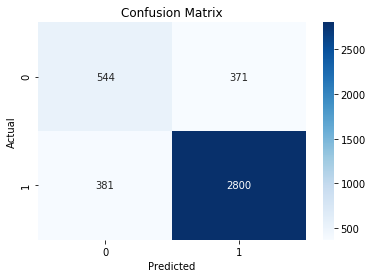

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       915
           1       0.88      0.88      0.88      3181

   micro avg       0.82      0.82      0.82      4096
   macro avg       0.74      0.74      0.74      4096
weighted avg       0.82      0.82      0.82      4096

Train score:  1.0
Test score:  0.81640625
Best Parameters: {'criterion': 'entropy'}


In [14]:
#4.Decision Tree
tree = DecisionTreeClassifier(random_state=0)

#define a list of parameters
#params_tree = {'criterion':['gini','entropy'],'splitter':['best','random'],'min_samples_split':[2,3],'min_samples_leaf':[2,3]}
params_tree = {'criterion':['gini','entropy']}
grid_tree = GridSearchCV(tree, params_tree, cv=3, scoring='accuracy')

grid_tree.fit(X_train, y_train)
y_pred_tree = grid_tree.predict(X_test)

#Model metrics
Report(grid_tree,X_train,X_test,y_train,y_test,y_pred_tree)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jo

Summary Metrics
Precision score: 0.8840
Recall score: 0.9010
Accuracy score: 0.8313
F1 score: 0.8924


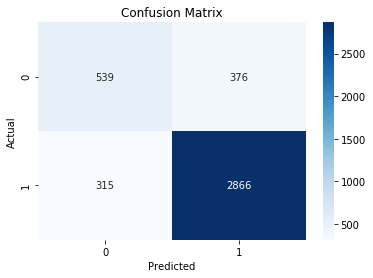

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       915
           1       0.88      0.90      0.89      3181

   micro avg       0.83      0.83      0.83      4096
   macro avg       0.76      0.75      0.75      4096
weighted avg       0.83      0.83      0.83      4096

Train score:  -0.03524336643333876


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


Test score:  -0.168701171875
Best Parameters: {'max_features': 3, 'n_estimators': 3}


In [15]:
#5.Random Forest
random_forest = RandomForestClassifier(random_state = 50, verbose = 1, n_jobs = -1)
#param_random = {'n_estimators': [3,4], 'max_features': [1,3], 'max_depth': [3, 6, None], 'bootstrap': [True, False]}
param_random = {'n_estimators': [3,4],'max_features': [1,3]}
grid_random = GridSearchCV(random_forest, param_random, cv=5, scoring='neg_mean_squared_error')
grid_random.fit(X_train, y_train)
y_pred_random = grid_random.predict(X_test)
#Model metrics
Report(grid_random,X_train,X_test,y_train,y_test,y_pred_random)

In [16]:
#Model Comparison
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

algoList = ["LogisticRegression", "Linear SVC","SVC RBF", "Decision Tree","Random Forest"]
comparison = {"Models" : algoList, "Accuracy" : compareAccuracy}
dfComparison = pd.DataFrame(comparison)

newIndex = (dfComparison.Accuracy.sort_values(ascending = False)).index.values
sorted_dfComparison = dfComparison.reindex(newIndex)


data = [go.Bar(
               x = sorted_dfComparison.Models,
               y = sorted_dfComparison.Accuracy,
               name = "Accuracy Scores of Models",
               marker = dict(color = "rgba(116,173,209,0.8)",
                             line=dict(color='rgb(0,0,0)',width=1.0)))]

layout = go.Layout(xaxis= dict(title= 'Models',ticklen= 5,zeroline= False))

fig = go.Figure(data = data, layout = layout)

iplot(fig)

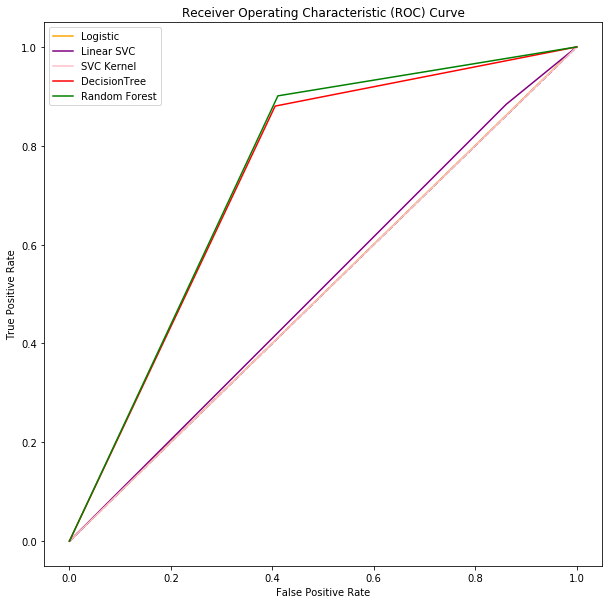

In [17]:
#ROC Curve

plt.figure(figsize = (10,10))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')


fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg)
plt.plot(fpr, tpr, color='orange', label='Logistic')

fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_svm)
plt.plot(fpr1, tpr1, color='purple', label='Linear SVC')

fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_svc_kernal)
plt.plot(fpr2, tpr2, color='pink', label='SVC Kernel')

fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_tree)
plt.plot(fpr3, tpr3, color='red', label='DecisionTree')

fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_random)
plt.plot(fpr4, tpr4, color='green', label='Random Forest')

plt.legend()
plt.show()

In [2]:
print("ROC curve :Top left most model is the best model.")
print("Accuracy of finding elderly people falling correctly is calculated should be high ")
print("Best Model: Random Forest")

ROC curve :Top left most model is the best model.
Accuracy of finding elderly people falling correctly is calculated should be high 
Best Model: Random Forest
